In [2]:
import pandas as pd
import numpy as np

INPUT = "C:/Users/hp/Downloads/all_companies_with_sectors_corrected.csv"

# 1) load data
df = pd.read_csv(INPUT, parse_dates=["Date"], low_memory=False)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

cols = ["PX_LAST", "REVENUE", "NET_INCOME", "IS_RD_EXPEND", "CAPEX", "CUR_MKT_CAP"]
for c in cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["CUR_MKT_CAP"])

vars_to_agg = ["PX_LAST", "REVENUE", "NET_INCOME", "IS_RD_EXPEND", "CAPEX"]
df = df.dropna(subset=vars_to_agg, how="all")


df["Quarter"] = df["Date"].dt.to_period("Q").astype(str)

def weighted_agg(group, value_cols, weight_col="CUR_MKT_CAP"):
    w = group[weight_col] if weight_col in group.columns else pd.Series(np.nan, index=group.index)
    out = {}
    for col in value_cols:
        if col not in group.columns:
            out[col] = np.nan
            continue
        val = group[col]
        mask = val.notna() & w.notna() & (w > 0)
        if mask.sum() == 0:
            out[col] = np.nan
        else:
            out[col] = np.average(val[mask], weights=w[mask])
    return pd.Series(out)


sector_df = (
    df.groupby(["Stream", "Quarter"])
      .apply(lambda g: weighted_agg(g, vars_to_agg, weight_col="CUR_MKT_CAP"))
      .reset_index()
)

print("Aggregated shape:", sector_df.shape)
display(sector_df.head(20))

Aggregated shape: (1557, 7)


C:\Users\hp\AppData\Local\Temp\ipykernel_45288\3942006555.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: weighted_agg(g, vars_to_agg, weight_col="CUR_MKT_CAP"))


,Stream,Quarter,PX_LAST,REVENUE,NET_INCOME,IS_RD_EXPEND,CAPEX
0,Downstream (Automotive Semiconductors),2000Q2,59.538,1830.0,266.0,237.0,NaN
1,Downstream (Automotive Semiconductors),2000Q3,39.572,2380.0,581.0,348.0,NaN
2,Downstream (Automotive Semiconductors),2000Q4,28.560,1658.0,280.0,257.0,NaN
3,Downstream (Automotive Semiconductors),2001Q1,30.762,1650.0,23.0,269.0,NaN
4,Downstream (Automotive Semiconductors),2001Q2,20.460,1277.0,-371.0,318.0,NaN
5,Downstream (Automotive Semiconductors),2001Q3,9.972,1085.0,-523.0,344.0,NaN
6,Downstream (Automotive Semiconductors),2001Q4,16.952,1034.0,-331.0,267.0,221.0
7,Downstream (Automotive Semiconductors),2002Q1,19.190,1385.0,-108.0,264.0,145.0
8,Downstream (Automotive Semiconductors),2002Q2,11.803,1404.0,-76.0,237.0,64.0
9,Downstream (Automotive Semiconductors),2002Q3,4.144,1384.0,-506.0,292.0,213.0


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_sector_revenue(sector_df, sectors_to_plot):
    # -------------------------------------------------
    # 1. Filter the data for the desired period & sectors
    # -------------------------------------------------
    df = sector_df[
        (sector_df["Quarter"] > "2000Q1") &
        (sector_df["Quarter"] <= "2025Q2") &
        (sector_df["Stream"].isin(sectors_to_plot))
    ].copy()

    print(f"Selected sectors: {sectors_to_plot}")
    print(f"Filtered dataset shape: {df.shape}")


    # -------------------------------------------------
    # 3. Compute Z-score normalization for REVENUE per sector
    # -------------------------------------------------
    df["REVENUE_ZSCORE"] = df.groupby("Stream")["REVENUE"].transform(
        lambda x: (x - x.mean()) / x.std(ddof=0)
    )

    # Drop missing values
    df = df.dropna(subset=["REVENUE_ZSCORE"])

    print("Data after Z-score normalization:")
    print(df[["Stream", "Quarter", "REVENUE_ZSCORE"]].head())

    # -------------------------------------------------
    # 4. Plot using Seaborn
    # -------------------------------------------------
    sns.set(style="whitegrid", context="talk")

    plt.figure(figsize=(30, 7))
    sns.lineplot(
        data=df,
        x="Quarter",
        y="REVENUE_ZSCORE",
        hue="Stream",
        lw=2,
        marker="o"
    )

    # -------------------------------------------------
    # 5. Chart styling
    # -------------------------------------------------
    plt.title("Comparison of Sector Revenues (Z-score Normalized)", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.xticks(rotation=90)

    plt.ylabel("Normalized Revenue (Z-score)", fontsize=14)
    plt.legend(title="Sector", loc="upper left")
    plt.grid(alpha=0.3)
    plt.show()



Selected sectors: ['Downstream (IC Design)', 'End Applications (Consumer Electronics)']
Filtered dataset shape: (202, 7)
Data after Z-score normalization:
                     Stream Quarter  REVENUE_ZSCORE
149  Downstream (IC Design)  2000Q2       -1.168464
150  Downstream (IC Design)  2000Q3       -1.170623
151  Downstream (IC Design)  2000Q4       -1.168704
152  Downstream (IC Design)  2001Q1       -1.189379
153  Downstream (IC Design)  2001Q2       -1.168665


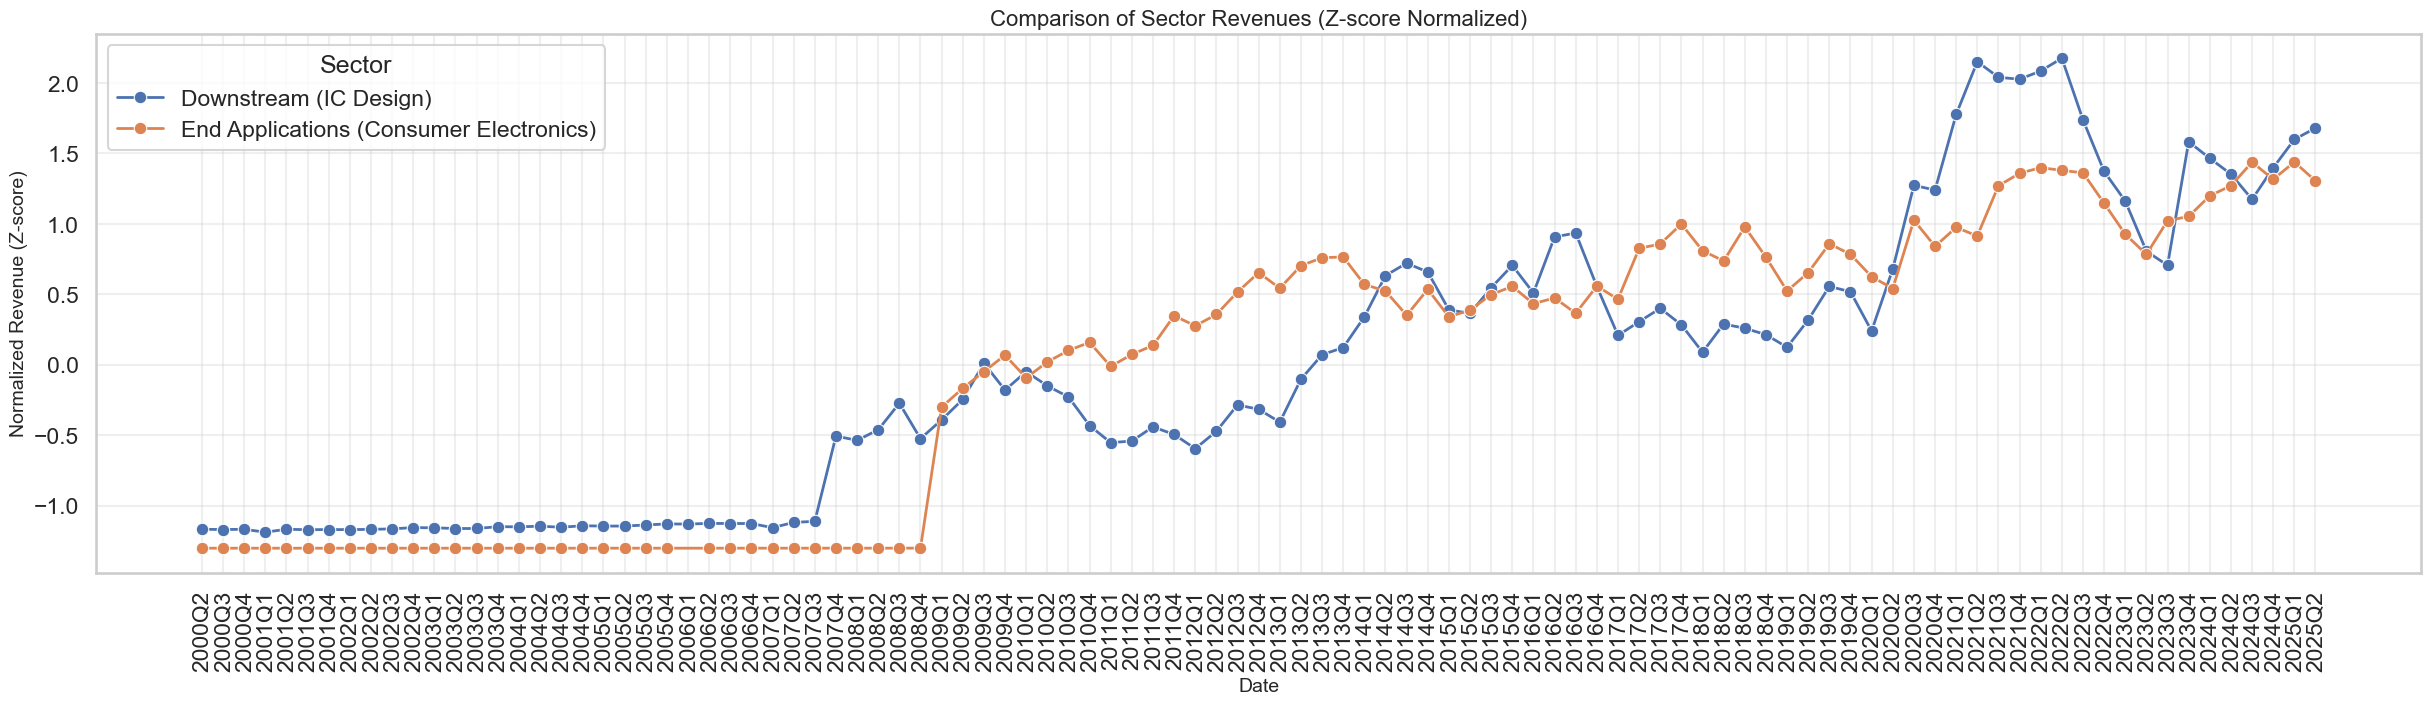

In [3]:
sectors_to_plot = [
"Downstream (IC Design)",
"End Applications (Consumer Electronics)"
]
plot_sector_revenue(sector_df, sectors_to_plot)

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name=""):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value         : {result[1]:.4f}")
    if result[1] < 0.05:
        print("  ✅ Stationary (reject H0)")
    else:
        print("  ❌ Non-stationary (cannot reject H0)")
    print("-"*40)

for sector in sectors_to_plot:
    tmp = sector_df[(sector_df["Quarter"] > "2000Q1") &
        (sector_df["Quarter"] <= "2025Q2") & (sector_df["Stream"] == sector)].sort_values("Quarter")
    adf_test(tmp["REVENUE"], sector)


ADF Test for Downstream (IC Design)
  Test Statistic : -0.6826
  p-value         : 0.8512
  ❌ Non-stationary (cannot reject H0)
----------------------------------------
ADF Test for End Applications (Consumer Electronics)
  Test Statistic : -0.8021
  p-value         : 0.8185
  ❌ Non-stationary (cannot reject H0)
----------------------------------------


In [10]:
tmp["REVENUE_DIFF"] = tmp["REVENUE"].diff()

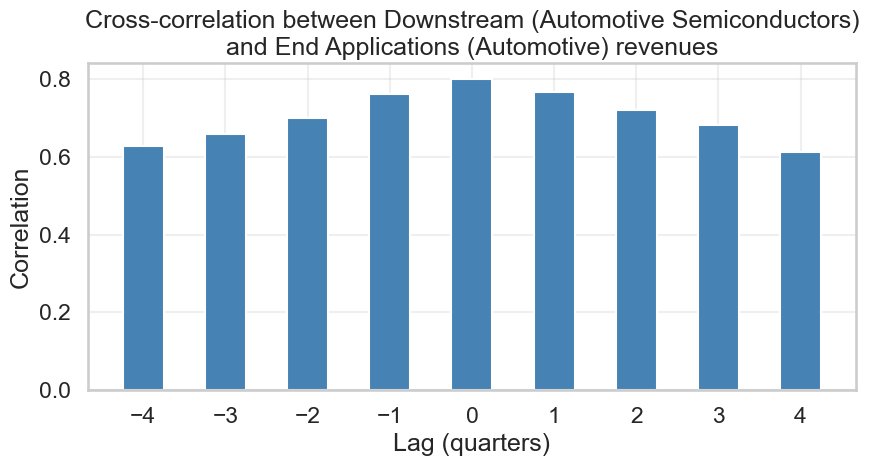

Cross-correlation values (negative → B leads A, positive → A leads B):
Lag -4: 0.6285
Lag -3: 0.6584
Lag -2: 0.7013
Lag -1: 0.7625
Lag +0: 0.8019
Lag +1: 0.7659
Lag +2: 0.7213
Lag +3: 0.6819
Lag +4: 0.6126


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import ccf

# ---------------------------------------------
# 1. Filter and align the two sectors
# ---------------------------------------------
sectorA = (
    sector_df[
        (sector_df["Quarter"] > "2010Q1")
        & (sector_df["Quarter"] <= "2025Q2")
        & (sector_df["Stream"] == "Downstream (IC Design)")
    ]
    .sort_values("Quarter")["REVENUE"]
)

sectorB = (
    sector_df[
        (sector_df["Quarter"] > "2010Q1")
        & (sector_df["Quarter"] <= "2025Q2")
        & (sector_df["Stream"] == "End Applications (Consumer Electronics)")
    ]
    .sort_values("Quarter")["REVENUE"]
)

# ---------------------------------------------
# 2. Compute cross-correlation for both directions
# ---------------------------------------------
corr_pos = ccf(sectorA, sectorB)          # A leads B (positive lags)
corr_neg = ccf(sectorB, sectorA)          # B leads A (negative lags)

max_lag = 4  # number of lags to show on each side

# Take only the first 4 values for both directions
corr_pos = corr_pos[:max_lag + 1]
corr_neg = corr_neg[:max_lag + 1][1:]  # skip lag=0 to avoid duplicate center

# Combine negative and positive parts symmetrically
corr_full = np.concatenate((corr_neg[::-1], corr_pos))  # optional: flip sign for symmetry
lags = list(range(-max_lag, max_lag + 1))

# ---------------------------------------------
# 3. Plot
# ---------------------------------------------
plt.figure(figsize=(9, 5))
plt.bar(lags, corr_full, color="steelblue", width=0.5)
plt.axhline(0, color="k", linewidth=0.8)
plt.title(
    "Cross-correlation between Downstream (Automotive Semiconductors)\n"
    "and End Applications (Automotive) revenues"
)
plt.xlabel("Lag (quarters)")
plt.ylabel("Correlation")
plt.xticks(range(-max_lag, max_lag + 1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 4. Print correlation values for interpretation
# ---------------------------------------------
print("Cross-correlation values (negative → B leads A, positive → A leads B):")
for lag, val in zip(lags, corr_full):
    print(f"Lag {lag:+d}: {val:.4f}")



In [14]:
from statsmodels.tsa.stattools import grangercausalitytests

data = pd.concat([sectorA.reset_index(drop=True), sectorB.reset_index(drop=True)], axis=1)
data.columns = sectors_to_plot

grangercausalitytests(data, maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6367  , p=0.4282  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=0.6702  , p=0.4130  , df=1
likelihood ratio test: chi2=0.6665  , p=0.4143  , df=1
parameter F test:         F=0.6367  , p=0.4282  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9734  , p=0.3843  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=2.1270  , p=0.3452  , df=2
likelihood ratio test: chi2=2.0896  , p=0.3518  , df=2
parameter F test:         F=0.9734  , p=0.3843  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3368  , p=0.7988  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=1.1491  , p=0.7652  , df=3
likelihood ratio test: chi2=1.1378  , p=0.7679  , df=3
parameter F test:         F=0.3368  , p=0.7988  , df_denom=51, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2708  , p=0.8954  , df_d

{np.int64(1): ({'ssr_ftest': (np.float64(0.636720070593798),
    np.float64(0.42821291946744267),
    np.float64(57.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.6702316532566295),
    np.float64(0.41297085383463683),
    np.int64(1)),
   'lrtest': (np.float64(0.6665158785178846),
    np.float64(0.41426897399803253),
    np.int64(1)),
   'params_ftest': (np.float64(0.6367200706225415),
    np.float64(0.42821291945707385),
    np.float64(57.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.973394685366691),
    np.float64(0.38432794345667765),
    np.float64(54.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.127047645801288),
    np.float64(0.34523710991485457),
    np.int64(2)),
   'lrtest': (np.float64(2.0896031561162545),
    np.float64(0.3517616096755429),
    np.int64(2)),
   'params_ftest': (np.float64(0.9733946853517186),
    np.float64(0.38432794346223287),
    np.float64(54.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
      

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests

# Inverse the order of columns: now testing if Automotive → Semiconductors
data_reverse = pd.concat([
    sectorB.reset_index(drop=True),
    sectorA.reset_index(drop=True)
], axis=1)
data_reverse.columns = sectors_to_plot[::-1]


# Run the Granger test for up to 4 lags
grangercausalitytests(data_reverse, maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6241  , p=0.0620  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=3.8149  , p=0.0508  , df=1
likelihood ratio test: chi2=3.6985  , p=0.0545  , df=1
parameter F test:         F=3.6241  , p=0.0620  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7254  , p=0.0745  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=5.9556  , p=0.0509  , df=2
likelihood ratio test: chi2=5.6738  , p=0.0586  , df=2
parameter F test:         F=2.7254  , p=0.0745  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2311  , p=0.0958  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=7.6121  , p=0.0547  , df=3
likelihood ratio test: chi2=7.1524  , p=0.0672  , df=3
parameter F test:         F=2.2311  , p=0.0958  , df_denom=51, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3965  , p=0.2494  , df_d

{np.int64(1): ({'ssr_ftest': (np.float64(3.624129340842187),
    np.float64(0.062000299334118714),
    np.float64(57.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(3.814872990360197),
    np.float64(0.050799456388734295),
    np.int64(1)),
   'lrtest': (np.float64(3.698503195908188),
    np.float64(0.054461303513380306),
    np.int64(1)),
   'params_ftest': (np.float64(3.62412933887698),
    np.float64(0.0620002994027405),
    np.float64(57.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.7254364650020277),
    np.float64(0.07453480979149073),
    np.float64(54.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(5.955583386485912),
    np.float64(0.050905123962989976),
    np.int64(2)),
   'lrtest': (np.float64(5.6738093338781255),
    np.float64(0.05860679303966383),
    np.int64(2)),
   'params_ftest': (np.float64(2.725436465002028),
    np.float64(0.07453480979149073),
    np.float64(54.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
      